In [ ]:
#Todo: 
#* threshold motif scores at 0 
#* PRC curves --> Merged in this notebooks. 




# How to train your DragoNN tutorial 3: 
## Interpreting features induced by DNN's across multiple types of motif grammars 

This tutorial is a supplement to the DragoNN manuscript and follows figure 7 in the manuscript. 

This tutorial will take 1 hour  if executed on a GPU. 

Please complete "Primer Tutorial 1- Exploring model architectures for a homotypic motif density simulation" prior to completing this tutorial. 

The architectures used in this tutorial were determined as optimal by hyperparameter grid search in "Primer Tutorial 3 - CNN Hyperparameter Tuning via Grid Search"


## Outline<a name='outline'>
<ol>
    <li><a href=#1>How to use this tutorial</a></li>
    <li><a href=#2>Defining helper functions for model training and interpretation</a></li>
    TODO: explain reference options. 
    <li><a href=#3>Simulating training data with simdna: Review of Tutorial 1</a></li>
    <li><a href=#4>Single Motif</a></li>
    <li><a href=#5>Homotypic motif density detection</a></li>
    <li><a href=#6>Homotypic motif density localization</a></li>
    <li><a href=#7>Multiple motifs (multi-task)</a></li>  
    <li><a href=#8>Heterotypic motifs spatial grammar</a></li>
    <li><a href=#9>Conclusions</a></li>
</ol>
Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.

 

## How to use this tutorial<a name='1'>
<a href=#outline>Home</a>

This tutorial utilizes a Jupyter/IPython Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](./tutorial_images/play_button.png)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](./tutorial_images/play_all_button.png)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](./tutorial_images/inspecting_code.png)


In [1]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install https://github.com/kundajelab/simdna/archive/0.3.zip
#!pip install https://github.com/kundajelab/dragonn/archive/keras_2.2_tensorflow_1.6_purekeras.zip


In [2]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')
import numpy as np 

Using TensorFlow backend.


We start by loading dragonn's tutorial utilities.

In [3]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Defining helper functions for model training and interpretation  <a name='2'>
<a href=#outline>Home</a>


For each type of simulation, we will perform a consistent set of tasks: 
* Define the optimal model architecture, as determined in Tutorial 2. This architecture will be specific to the simulation used, so we don't write a universal helper function for this purpose. 
* Train the model on simulation data and visualize the model's learning curve on training and validation data. 
* Compute the model's performance on a held-out test set.
* Visualize motif scores for a positive and negative example. 
* Perform in silico mutagenesis for a positive and negative example.
* Compute DeepLIFT scores for a positive and negative example.

To avoid writing the same code for each scenario, we define a series of helpers functions to perform the tasks above. 

In [4]:
from dragonn.callbacks import * 
from dragonn.vis import plot_learning_curve

def train_model(model,data):
    #We define a custom callback to print training and validation metrics while training. 
    metrics_callback=MetricsCallback(train_data=(data.X_train,data.y_train),validation_data=(data.X_valid,data.y_valid))
    
    #Train the model 
    history=model.fit(x=data.X_train,
                      y=data.y_train,
                      batch_size=128,
                      epochs=150,
                      verbose=0,
                      callbacks=[EarlyStopping(patience=7,restore_best_weights=True),
                                History(),
                                metrics_callback],
                                validation_data=(data.X_valid,data.y_valid))
    
    #Visualize the model's performance curve 
    plot_learning_curve(history)
    return model

In [5]:
#Compute model performance on a held out test set 
def compute_performance(model,data):
    test_predictions=model.predict(data.X_test)
    ## Generate a ClassificationResult object to print performance metrics on held-out test set 
    print(ClassificationResult(data.y_test,test_predictions))


In [6]:
def extract_pos_and_neg_validation_sample(data,pos_index,neg_index):
#get the indices of the specified positive and negative examples in the validation data split
    pos_index=np.flatnonzero(data.y_valid==1)[pos_index]
    pos_X=data.X_valid[pos_index:pos_index+1]
    neg_index=np.flatnonzero(data.y_valid==0)[neg_index]
    neg_X=data.X_valid[neg_index:neg_index+1]
    return pos_X,neg_X

In [7]:
#Run the full data analysis for a given dataset and model 
#Train the model, compute it's performance on a positive and negative data point 
from dragonn.interpret import * 
def analyze(model,data,pos_index,neg_index,outfname,motif_names,xlim_for_plot):
    
    '''
    model -- keras model object 
    data -- simulated dataset object 
    pos_index -- numberical index of positive test example (within the data object) that should be interpreted 
    neg_index -- numberical index of negative test eample (within the data object) that should be interpreted 
    outfname -- name of output file to save the keras model 
    motif_names -- list of motif names used in the simulation 
    xlim_for_plot -- tuple indicating start and end x-coordinates of sequence example (0-indexed) to show in interpretation plot 

    Returns: 
    pos_X -- one-hot-encoded positive example that was used in interpretation 
    neg_X -- one-hot-encoded negative example that was used in interpretation 
    pos_interpretation -- dictionary of interpretation metrics for positive example 
    neg_interpretation -- dictionary of interpretation metrics for negative example 
    
    '''
    
    #Train the model
    model=train_model(model,data)
    #Compute model performance on a held-out test set 
    compute_performance(model,data)
    #save the model to an output file 
    model.save(outfname)
    #Extract positive and negative examples for interpretation 
    pos_X,neg_X=extract_pos_and_neg_validation_sample(data,pos_index,neg_index)
    #Get the deepLIFT scoring function
    dl_score_func=get_deeplift_scoring_function(outfname,
                                           target_layer_idx=-2,
                                           task_idx=0,
                                           num_refs_per_seq=10,
                                           reference='shuffled_ref',
                                           one_hot_func=None)
    #perform interpretation 
    pos_interpretations=multi_method_interpret(model,
                                           pos_X,
                                           0,
                                           dl_score_func,
                                           motif_names=motif_names)
    neg_interpretations=multi_method_interpret(model,
                                           neg_X,
                                           0,
                                           dl_score_func,
                                           motif_names=motif_names)
    return pos_X,neg_X, pos_interpretations, neg_interpretations 


Finally, we set a random seed to ensure that all analyses in this tutorial are reproducible. 

In [8]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

## Getting simulation data <a name='3'>
<a href=#outline>Home</a>


DragoNN provides a set of simulation functions. Let's use the **print_available_simulations** function to examine the list of simulations supported by DragoNN:

In [9]:
from dragonn.simulations import * 
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection


## Single Motif <a name='4'>
<a href=#outline>Home</a>


We begin with single motif detection of the TAL1_known4 motif: 

![play button](./tutorial_images/TAL1_known4.png)
Let's find out what parameters are needed for the simulation: 

In [10]:
print_simulation_info("simulate_single_motif_detection")


    Simulates two classes of seqeuences:
        - Positive class sequence with a motif
          embedded anywhere in the sequence
        - Negative class sequence without the motif

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Array with sequence strings.
    y : 1darray
        Array with positive/negative class labels.
    embedding_arr: 1darray
        Array of embedding objects.
    


In this binary simulation task, we simulate a negative set of 10K 500 bp random sequences and a positive set of 10K 500 bp random sequences with one instance of the TAL1 motif randomly embedded at any position.

In [11]:
#Define simulation parameters 
tal1_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 500, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data 
tal1_data = get_simulation_data("simulate_single_motif_detection",
                                      tal1_parameters,
                                      validation_set_size=3200, test_set_size=4000)


We define the convolutional neural network model architecture: 

In [12]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
tal1_model=Sequential() 
tal1_model.add(Conv2D(filters=10,kernel_size=(1,15),input_shape=tal1_data.X_train.shape[1::]))
tal1_model.add(Activation('relu'))
tal1_model.add(MaxPooling2D(pool_size=(1,35)))
tal1_model.add(Flatten())
tal1_model.add(Dense(1))
tal1_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
tal1_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.
Training Data:
Loss: 0.6929	Balanced Accuracy: 51.89%	 auROC: 0.527	 auPRC Careful: 0.517	 auPRC Trapezoidal: 0.517
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.6976	Balanced Accuracy: 49.91%	 auROC: 0.501	 auPRC Careful: 0.500	 auPRC Trapezoidal: 0.499
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.6896	Balanced Accuracy: 53.02%	 auROC: 0.546	 auPRC Careful: 0.534	 auPRC Trapezoidal: 0.534
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.6963	Balanced Accuracy: 50.84%	 auROC: 0.507	 auPRC Careful: 0.505	 auPRC Trapezoidal: 0.505
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.6869	Balanced Accuracy: 54.28%	 auROC: 0.564	 auPRC Careful: 0.550	 auPRC Trapezoidal: 0.550
	Recall at 5%|10%|20% FDR: 0.0%|

Training Data:
Loss: 0.5112	Balanced Accuracy: 78.63%	 auROC: 0.862	 auPRC Careful: 0.842	 auPRC Trapezoidal: 0.842
	Recall at 5%|10%|20% FDR: 2.4%|29.7%|75.7%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.5212	Balanced Accuracy: 77.34%	 auROC: 0.850	 auPRC Careful: 0.842	 auPRC Trapezoidal: 0.842
	Recall at 5%|10%|20% FDR: 11.4%|36.4%|71.9%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.4985	Balanced Accuracy: 79.99%	 auROC: 0.873	 auPRC Careful: 0.853	 auPRC Trapezoidal: 0.853
	Recall at 5%|10%|20% FDR: 2.4%|35.7%|79.3%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.5080	Balanced Accuracy: 79.03%	 auROC: 0.862	 auPRC Careful: 0.854	 auPRC Trapezoidal: 0.854
	Recall at 5%|10%|20% FDR: 12.6%|41.0%|76.9%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.4862	Balanced Accuracy: 80.61%	 auROC: 0.881	 auPRC Careful: 0.861	 auPRC Trapezoidal: 0.861
	Recall at 5%|10%|20% FDR: 2.5%|41.0%|82.7%	 Num Positives: 6355	 Num 

Training Data:
Loss: 0.3432	Balanced Accuracy: 88.19%	 auROC: 0.935	 auPRC Careful: 0.924	 auPRC Trapezoidal: 0.924
	Recall at 5%|10%|20% FDR: 51.8%|84.4%|94.4%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3538	Balanced Accuracy: 87.03%	 auROC: 0.929	 auPRC Careful: 0.925	 auPRC Trapezoidal: 0.925
	Recall at 5%|10%|20% FDR: 42.4%|81.6%|93.6%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.3390	Balanced Accuracy: 88.50%	 auROC: 0.935	 auPRC Careful: 0.924	 auPRC Trapezoidal: 0.924
	Recall at 5%|10%|20% FDR: 50.7%|84.6%|94.4%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3492	Balanced Accuracy: 87.62%	 auROC: 0.930	 auPRC Careful: 0.925	 auPRC Trapezoidal: 0.924
	Recall at 5%|10%|20% FDR: 48.4%|81.8%|93.6%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.3348	Balanced Accuracy: 88.59%	 auROC: 0.937	 auPRC Careful: 0.925	 auPRC Trapezoidal: 0.925
	Recall at 5%|10%|20% FDR: 54.5%|85.5%|94.5%	 Num Positives: 6355	 N

Training Data:
Loss: 0.2969	Balanced Accuracy: 90.04%	 auROC: 0.946	 auPRC Careful: 0.937	 auPRC Trapezoidal: 0.937
	Recall at 5%|10%|20% FDR: 65.5%|90.0%|95.2%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3130	Balanced Accuracy: 89.19%	 auROC: 0.937	 auPRC Careful: 0.935	 auPRC Trapezoidal: 0.935
	Recall at 5%|10%|20% FDR: 63.2%|88.2%|93.8%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.2958	Balanced Accuracy: 90.09%	 auROC: 0.946	 auPRC Careful: 0.937	 auPRC Trapezoidal: 0.937
	Recall at 5%|10%|20% FDR: 65.6%|90.0%|95.2%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3120	Balanced Accuracy: 89.22%	 auROC: 0.937	 auPRC Careful: 0.935	 auPRC Trapezoidal: 0.935
	Recall at 5%|10%|20% FDR: 62.8%|88.1%|93.8%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.2956	Balanced Accuracy: 90.30%	 auROC: 0.946	 auPRC Careful: 0.938	 auPRC Trapezoidal: 0.938
	Recall at 5%|10%|20% FDR: 66.8%|90.3%|95.3%	 Num Positives: 6355	 N

Training Data:
Loss: 0.2834	Balanced Accuracy: 90.45%	 auROC: 0.950	 auPRC Careful: 0.942	 auPRC Trapezoidal: 0.942
	Recall at 5%|10%|20% FDR: 71.0%|91.4%|95.6%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3070	Balanced Accuracy: 89.47%	 auROC: 0.939	 auPRC Careful: 0.938	 auPRC Trapezoidal: 0.938
	Recall at 5%|10%|20% FDR: 69.5%|89.5%|94.2%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.2823	Balanced Accuracy: 90.55%	 auROC: 0.949	 auPRC Careful: 0.942	 auPRC Trapezoidal: 0.942
	Recall at 5%|10%|20% FDR: 71.5%|91.3%|95.6%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3055	Balanced Accuracy: 89.62%	 auROC: 0.939	 auPRC Careful: 0.938	 auPRC Trapezoidal: 0.938
	Recall at 5%|10%|20% FDR: 69.4%|89.6%|94.4%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.2821	Balanced Accuracy: 90.60%	 auROC: 0.950	 auPRC Careful: 0.942	 auPRC Trapezoidal: 0.942
	Recall at 5%|10%|20% FDR: 71.0%|91.3%|95.6%	 Num Positives: 6355	 N

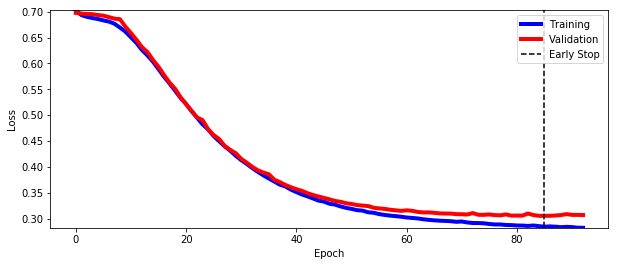

Loss: 0.3376	Balanced Accuracy: 88.46%	 auROC: 0.929	 auPRC Careful: 0.921	 auPRC Trapezoidal: 0.920
	Recall at 5%|10%|20% FDR: 12.6%|86.2%|94.2%	 Num Positives: 2045	 Num Negatives: 1955
getting 'motif_scan' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value
getting 'motif_scan' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


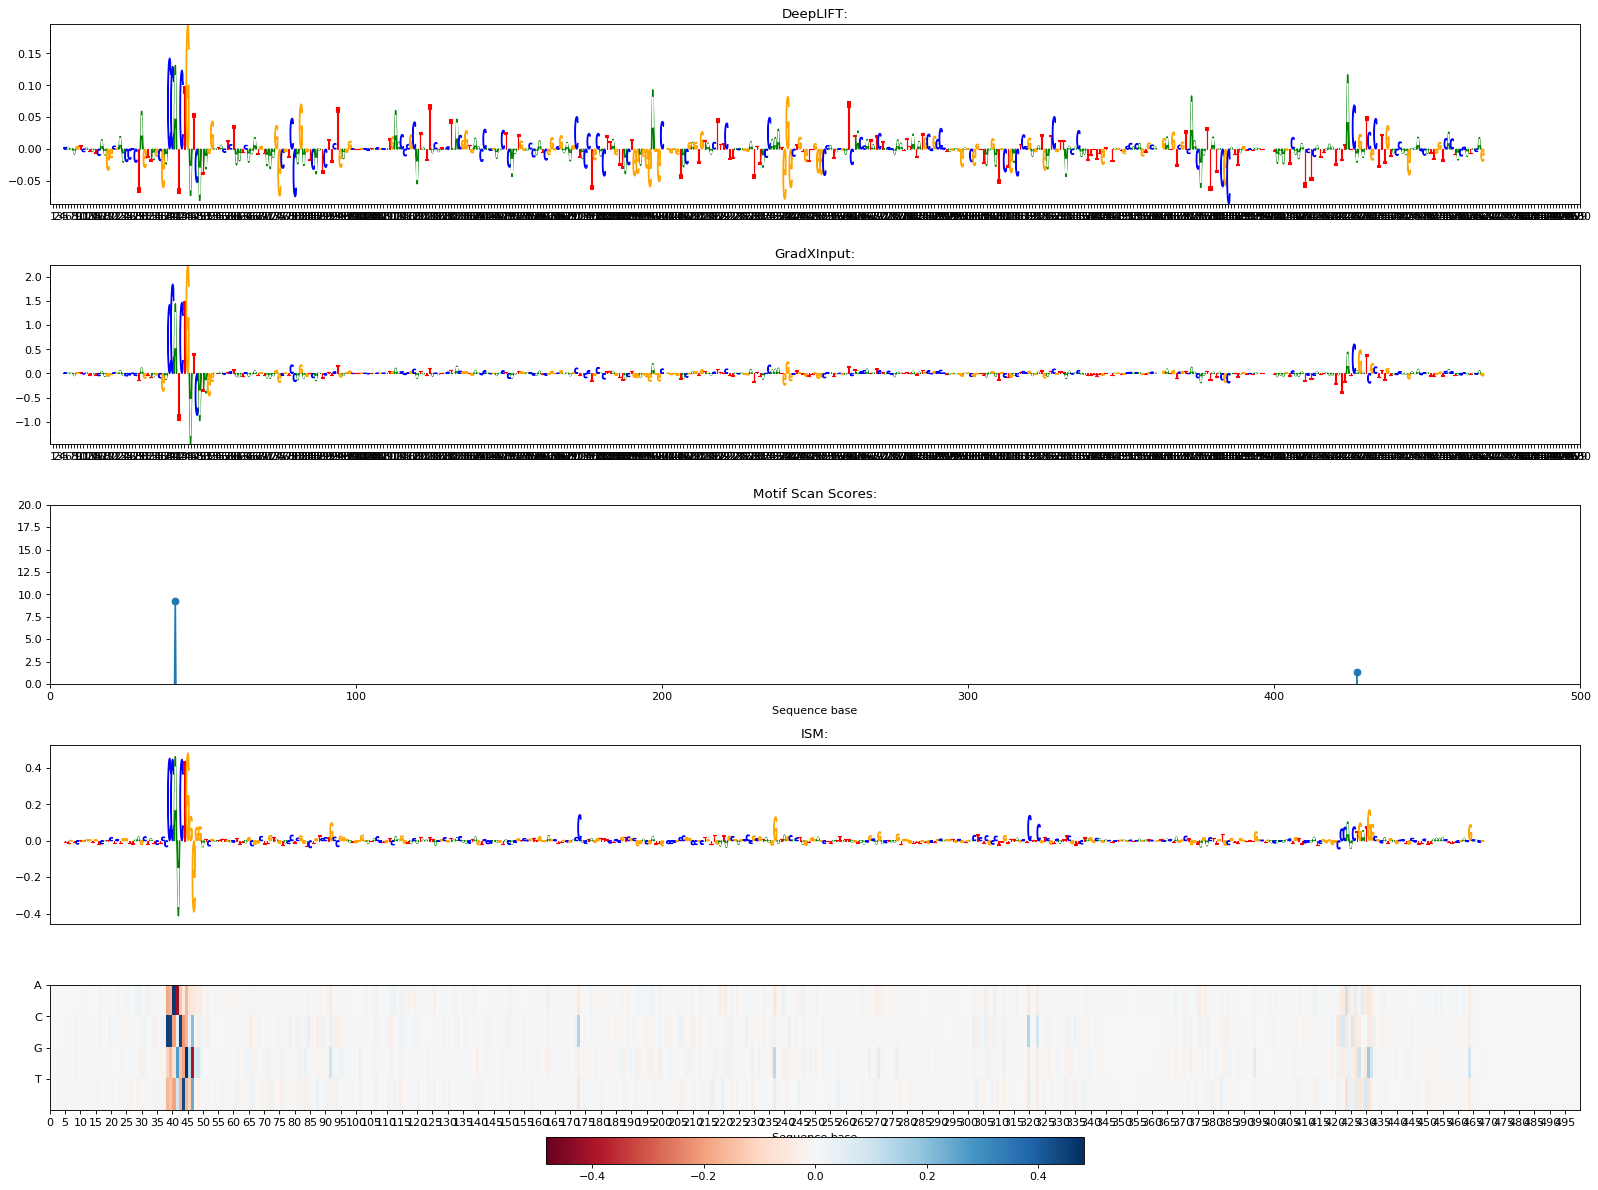

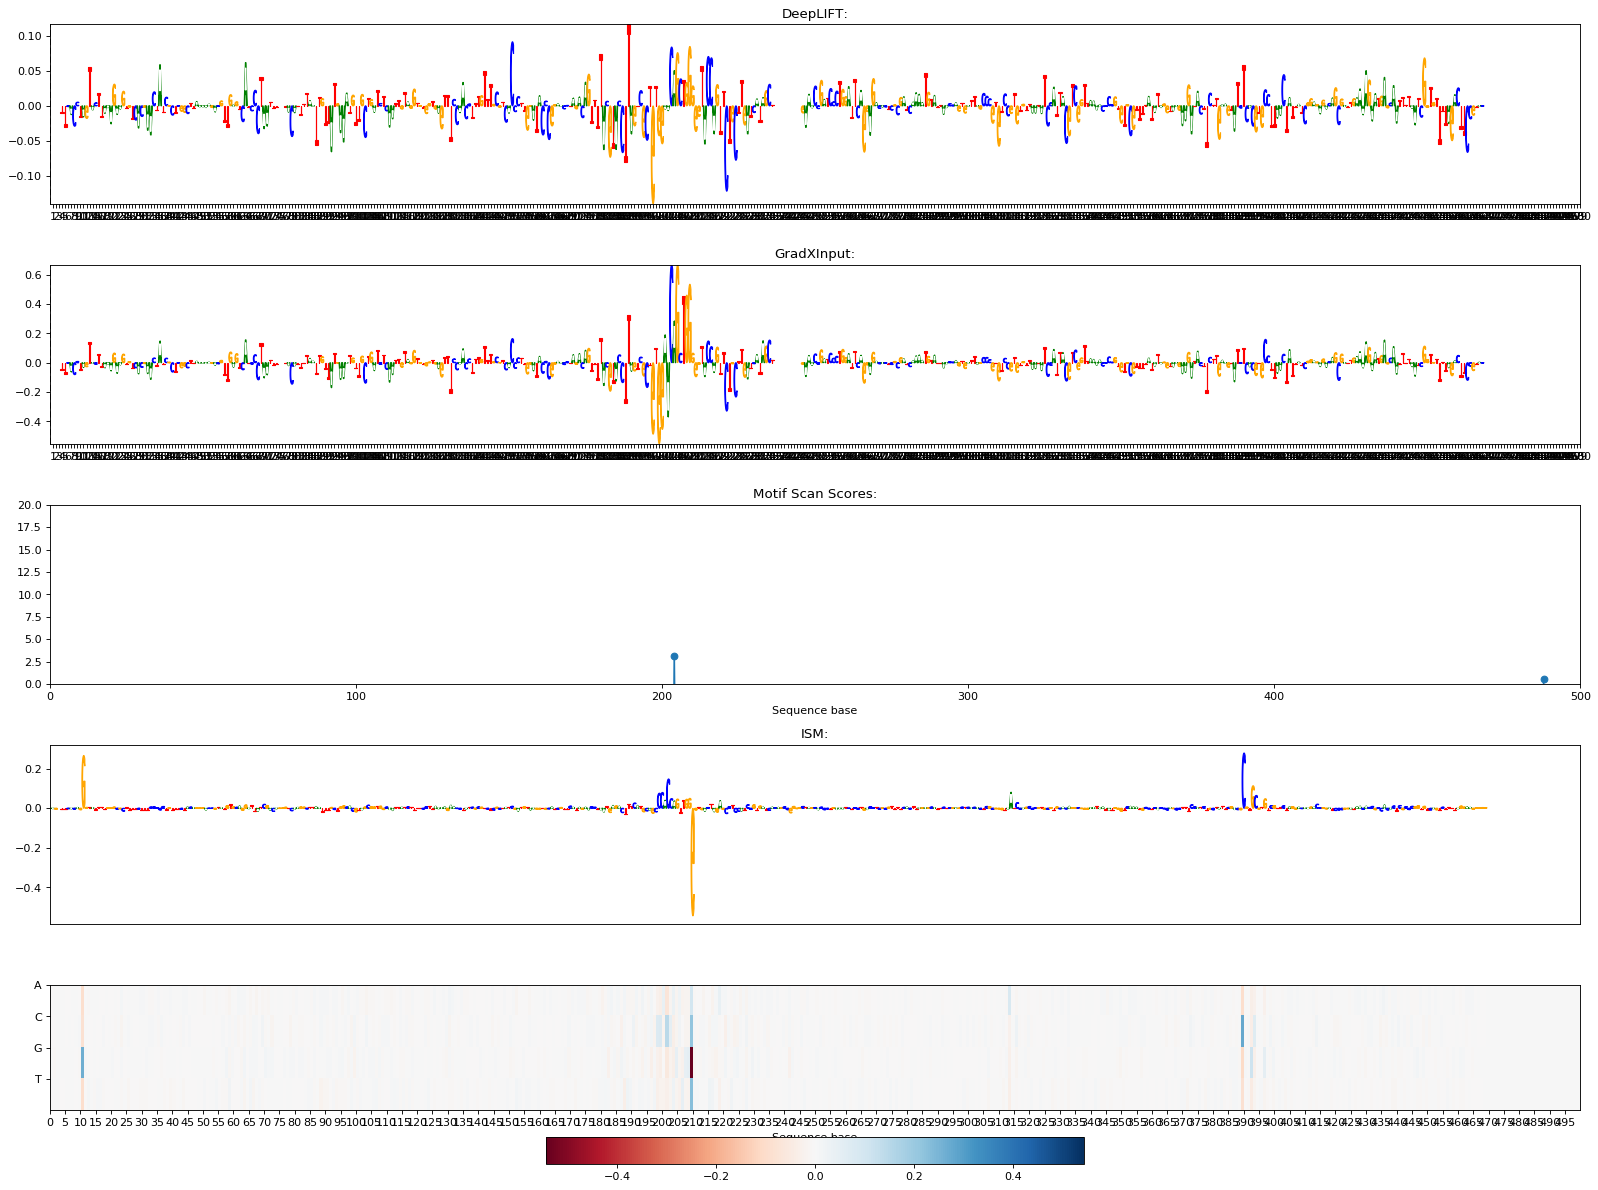

In [13]:
single_motif_pos_X,single_motif_neg_X, single_motif_pos_interpretations, single_motif_neg_interpretations = analyze(tal1_model,tal1_data,1,1,"tut3_single_motif_detection.hdf5",["TAL1_known4"],(0,500))

Let's zoom in to the portion of the interpretation track with the strongest signal:

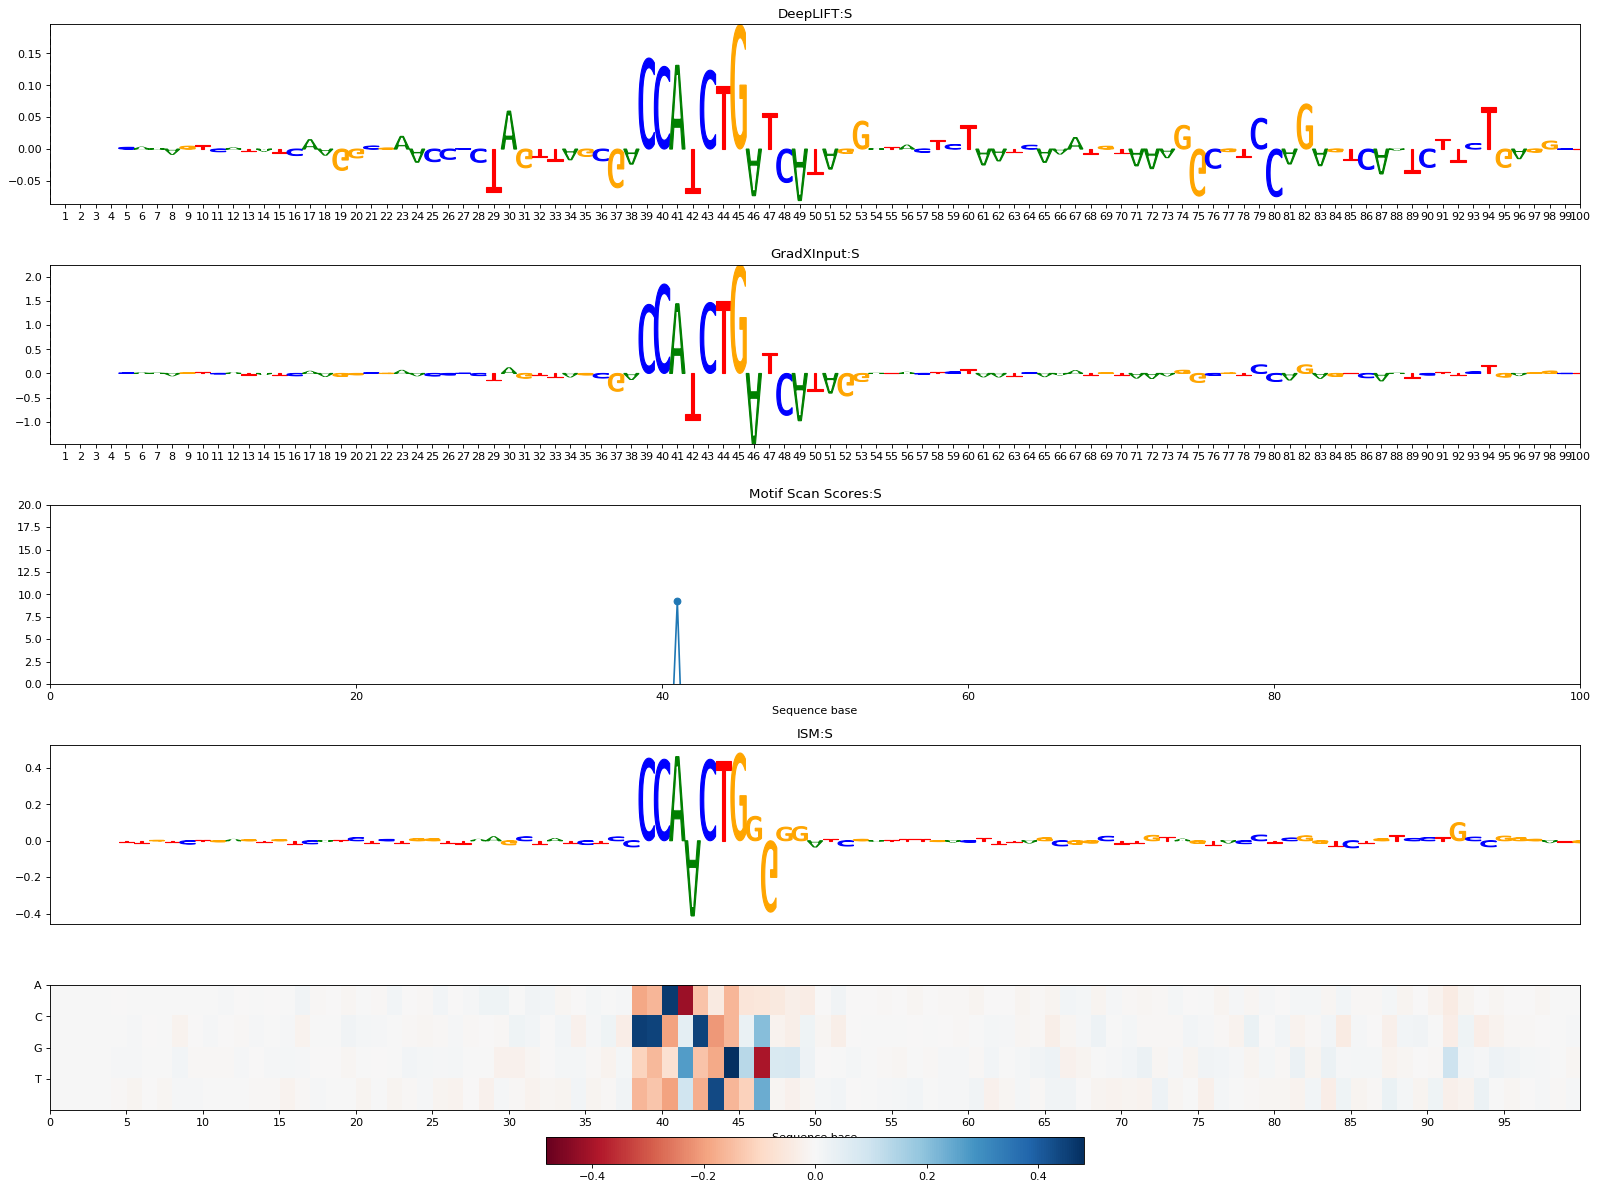

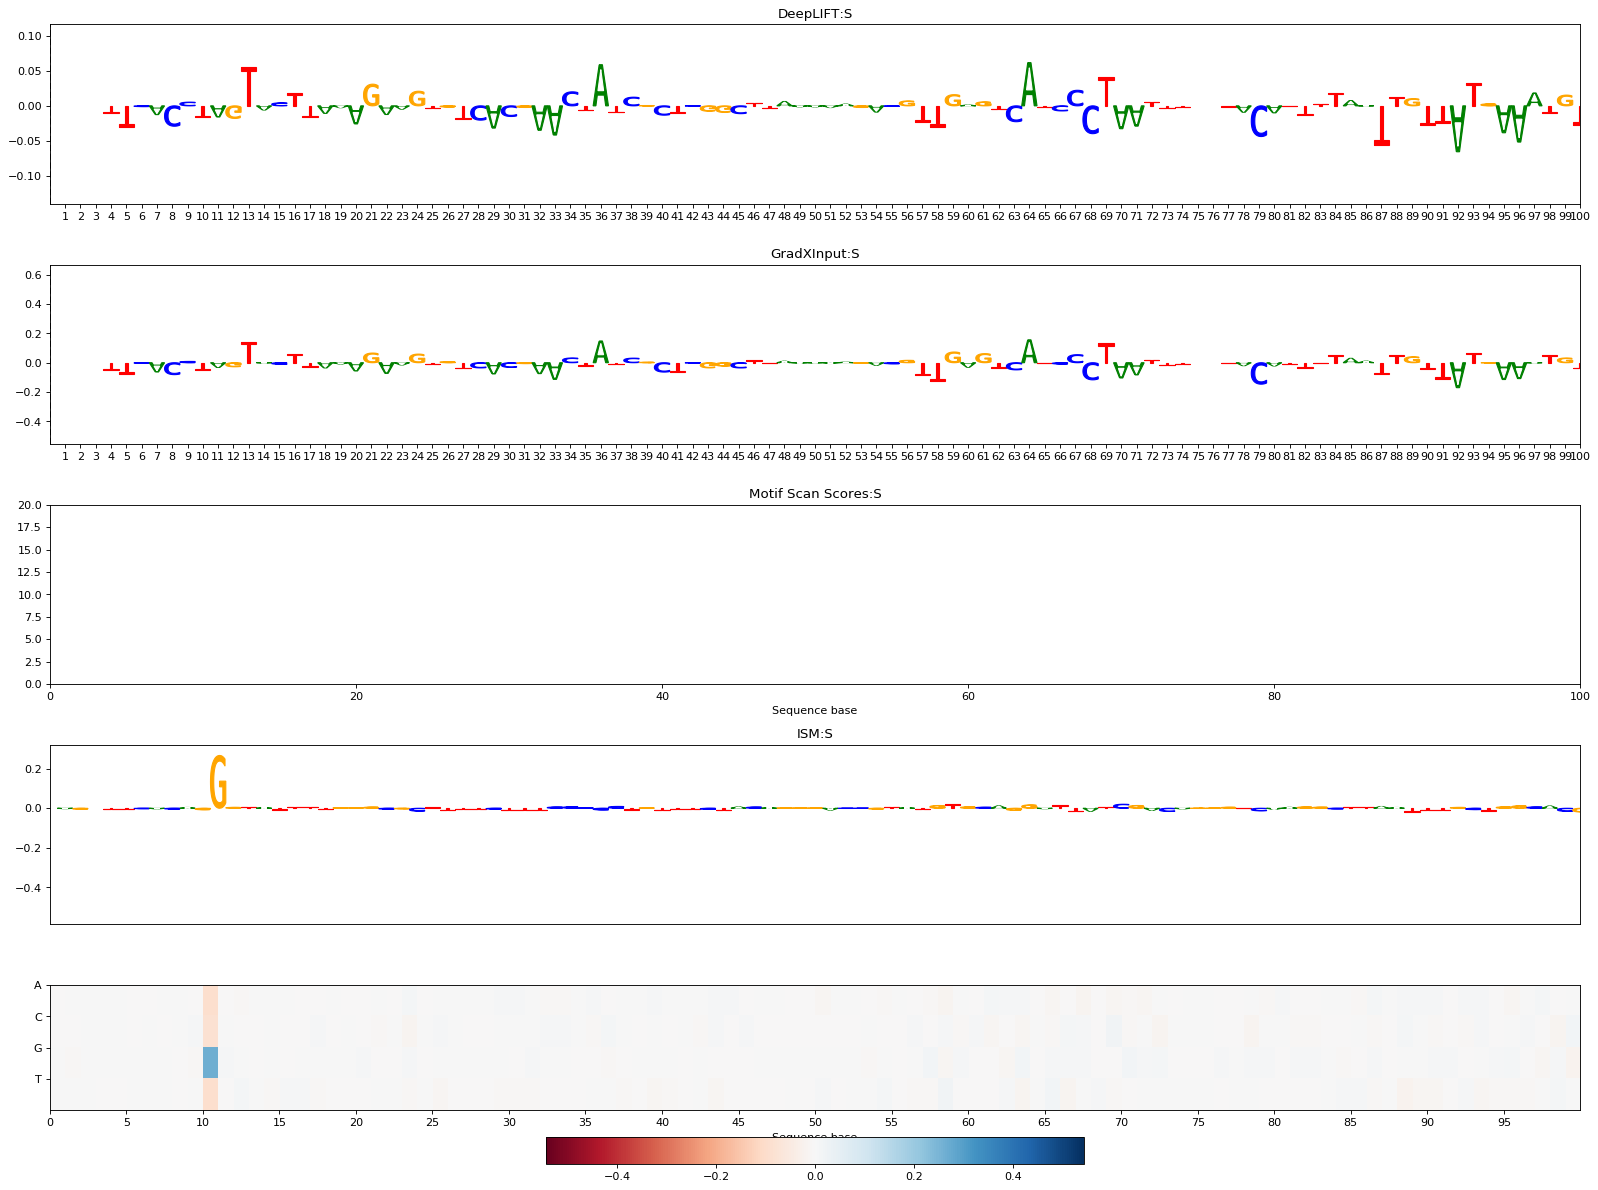

In [14]:
from dragonn.vis import * 
plot_all_interpretations([single_motif_pos_interpretations],single_motif_pos_X,xlim=(0,100),title="Single Motif, Positive")


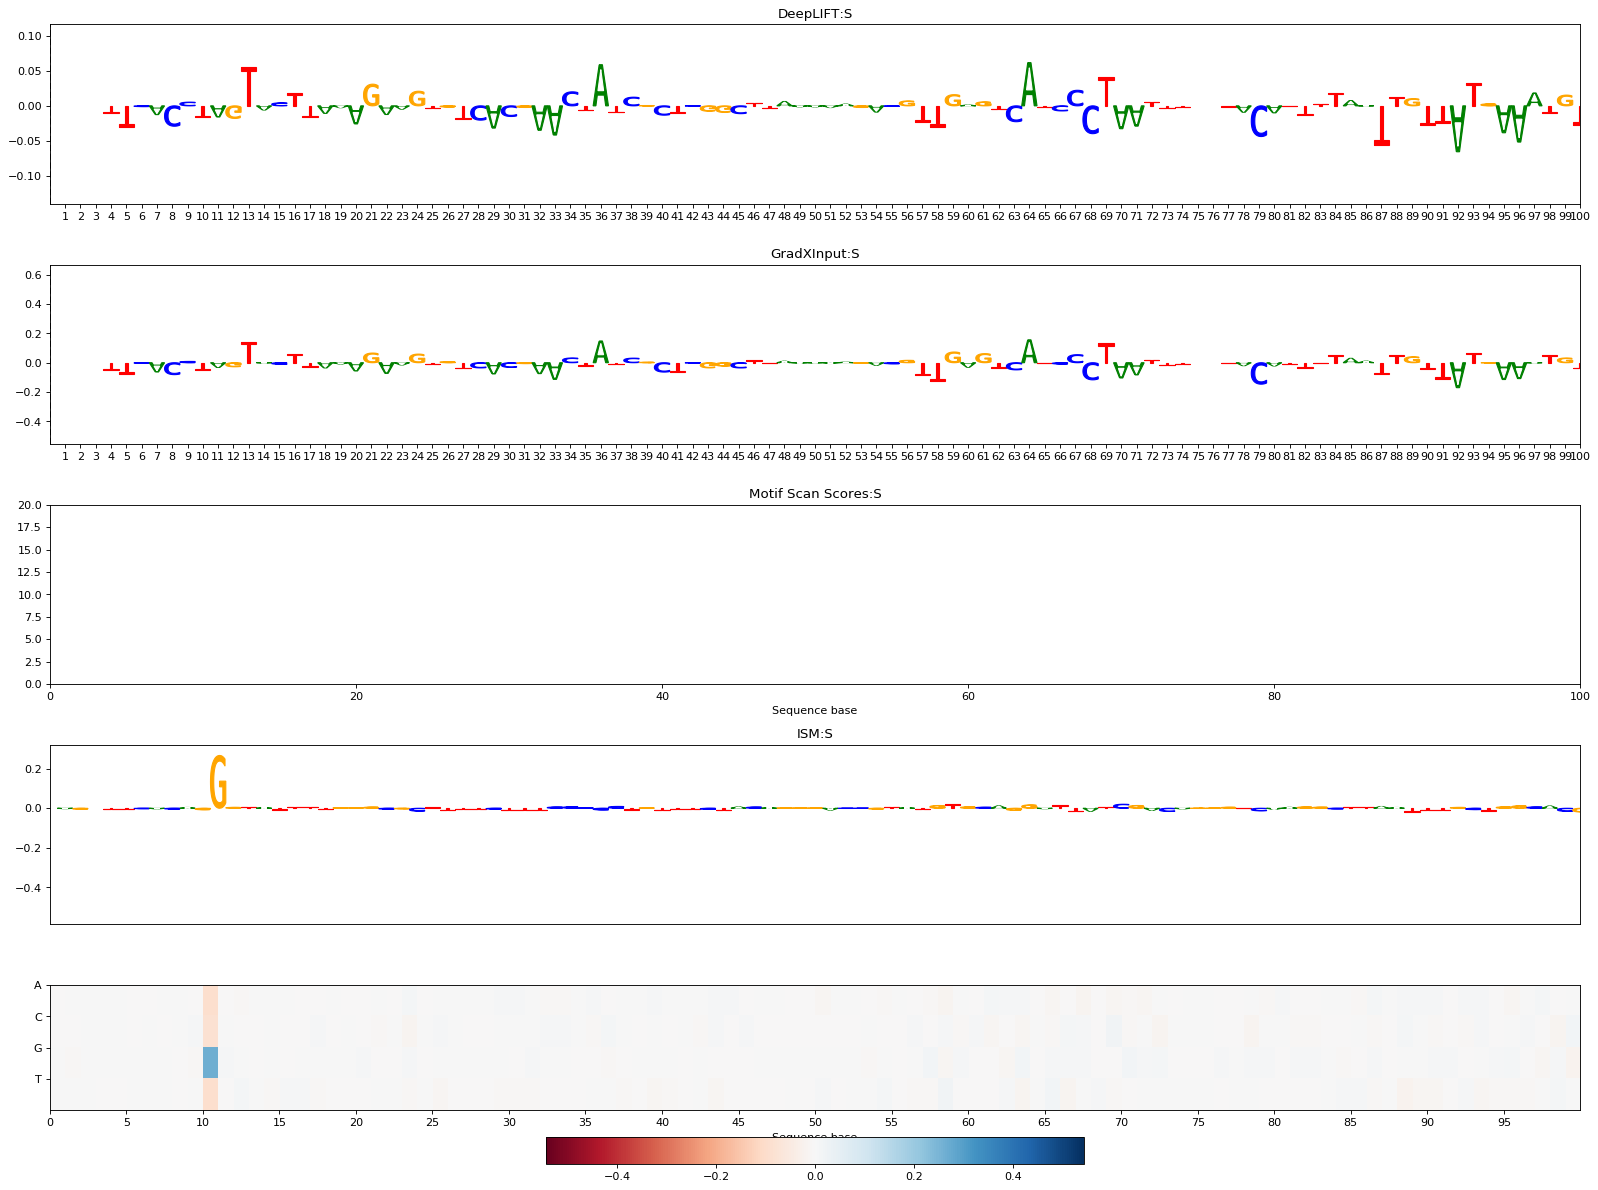

In [17]:
plot_all_interpretations([single_motif_neg_interpretations],single_motif_neg_X,xlim=(0,100),title="Single Motif, Negative")


## Homotypic motif density detection <a name='5'>
<a href=#outline>Home</a>

In [18]:
#Define simulation parameters 
density_detection_parameters={
    "motif_name": "TAL1_known4",
    "seq_length": 500,
    "neg_counts":[0,2],
    "pos_counts":[3,5],
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data
density_detection_data=get_simulation_data("simulate_motif_counting",
                               density_detection_parameters,
                               validation_set_size=3200,test_set_size=4000)



In [19]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
density_detection_model=Sequential() 
density_detection_model.add(Conv2D(filters=10,kernel_size=(1,15),input_shape=density_detection_data.X_train.shape[1::]))
density_detection_model.add(Activation('relu'))
density_detection_model.add(MaxPooling2D(pool_size=(1,35)))
density_detection_model.add(Flatten())
density_detection_model.add(Dense(1))
density_detection_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
density_detection_model.compile(optimizer='adam',
                               loss='binary_crossentropy')


Training Data:
Loss: 0.6956	Balanced Accuracy: 51.46%	 auROC: 0.517	 auPRC Careful: 0.515	 auPRC Trapezoidal: 0.515
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6389	 Num Negatives: 6411
Validation Data:
Loss: 0.6949	Balanced Accuracy: 51.00%	 auROC: 0.519	 auPRC Careful: 0.520	 auPRC Trapezoidal: 0.519
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.6854	Balanced Accuracy: 55.28%	 auROC: 0.574	 auPRC Careful: 0.568	 auPRC Trapezoidal: 0.568
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.1%	 Num Positives: 6389	 Num Negatives: 6411
Validation Data:
Loss: 0.6874	Balanced Accuracy: 53.37%	 auROC: 0.564	 auPRC Careful: 0.557	 auPRC Trapezoidal: 0.556
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.6633	Balanced Accuracy: 62.35%	 auROC: 0.673	 auPRC Careful: 0.673	 auPRC Trapezoidal: 0.673
	Recall at 5%|10%|20% FDR: 0.0%|0.5%|13.9%	 Num Positives: 6389	 Num Negatives: 

Training Data:
Loss: 0.2151	Balanced Accuracy: 91.37%	 auROC: 0.974	 auPRC Careful: 0.974	 auPRC Trapezoidal: 0.974
	Recall at 5%|10%|20% FDR: 84.9%|92.8%|97.9%	 Num Positives: 6389	 Num Negatives: 6411
Validation Data:
Loss: 0.2275	Balanced Accuracy: 90.60%	 auROC: 0.970	 auPRC Careful: 0.971	 auPRC Trapezoidal: 0.971
	Recall at 5%|10%|20% FDR: 83.3%|91.3%|97.4%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.2119	Balanced Accuracy: 91.47%	 auROC: 0.974	 auPRC Careful: 0.975	 auPRC Trapezoidal: 0.975
	Recall at 5%|10%|20% FDR: 85.2%|93.0%|97.9%	 Num Positives: 6389	 Num Negatives: 6411
Validation Data:
Loss: 0.2254	Balanced Accuracy: 90.68%	 auROC: 0.970	 auPRC Careful: 0.972	 auPRC Trapezoidal: 0.972
	Recall at 5%|10%|20% FDR: 83.6%|91.5%|97.5%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.2096	Balanced Accuracy: 91.52%	 auROC: 0.975	 auPRC Careful: 0.975	 auPRC Trapezoidal: 0.975
	Recall at 5%|10%|20% FDR: 85.4%|93.2%|97.9%	 Num Positives: 6389	 N

Training Data:
Loss: 0.1874	Balanced Accuracy: 92.53%	 auROC: 0.979	 auPRC Careful: 0.979	 auPRC Trapezoidal: 0.979
	Recall at 5%|10%|20% FDR: 88.6%|94.1%|98.2%	 Num Positives: 6389	 Num Negatives: 6411
Validation Data:
Loss: 0.2166	Balanced Accuracy: 90.96%	 auROC: 0.971	 auPRC Careful: 0.973	 auPRC Trapezoidal: 0.973
	Recall at 5%|10%|20% FDR: 84.0%|92.7%|97.6%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: nan	Balanced Accuracy: 92.47%	 auROC: 0.979	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 88.6%|94.2%|98.3%	 Num Positives: 6389	 Num Negatives: 6411
Validation Data:
Loss: 0.2173	Balanced Accuracy: 91.04%	 auROC: 0.971	 auPRC Careful: 0.973	 auPRC Trapezoidal: 0.973
	Recall at 5%|10%|20% FDR: 83.9%|92.6%|97.5%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: nan	Balanced Accuracy: 92.02%	 auROC: 0.979	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 88.7%|94.2%|98.3%	 Num Positives: 6389	 Num Neg

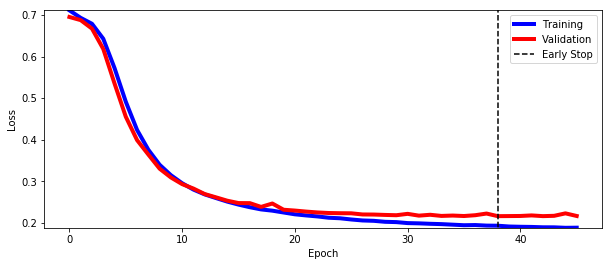

Loss: 0.2083	Balanced Accuracy: 91.00%	 auROC: 0.974	 auPRC Careful: 0.974	 auPRC Trapezoidal: 0.974
	Recall at 5%|10%|20% FDR: 83.8%|92.5%|97.8%	 Num Positives: 1994	 Num Negatives: 2006
getting 'motif_scan' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value
getting 'motif_scan' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


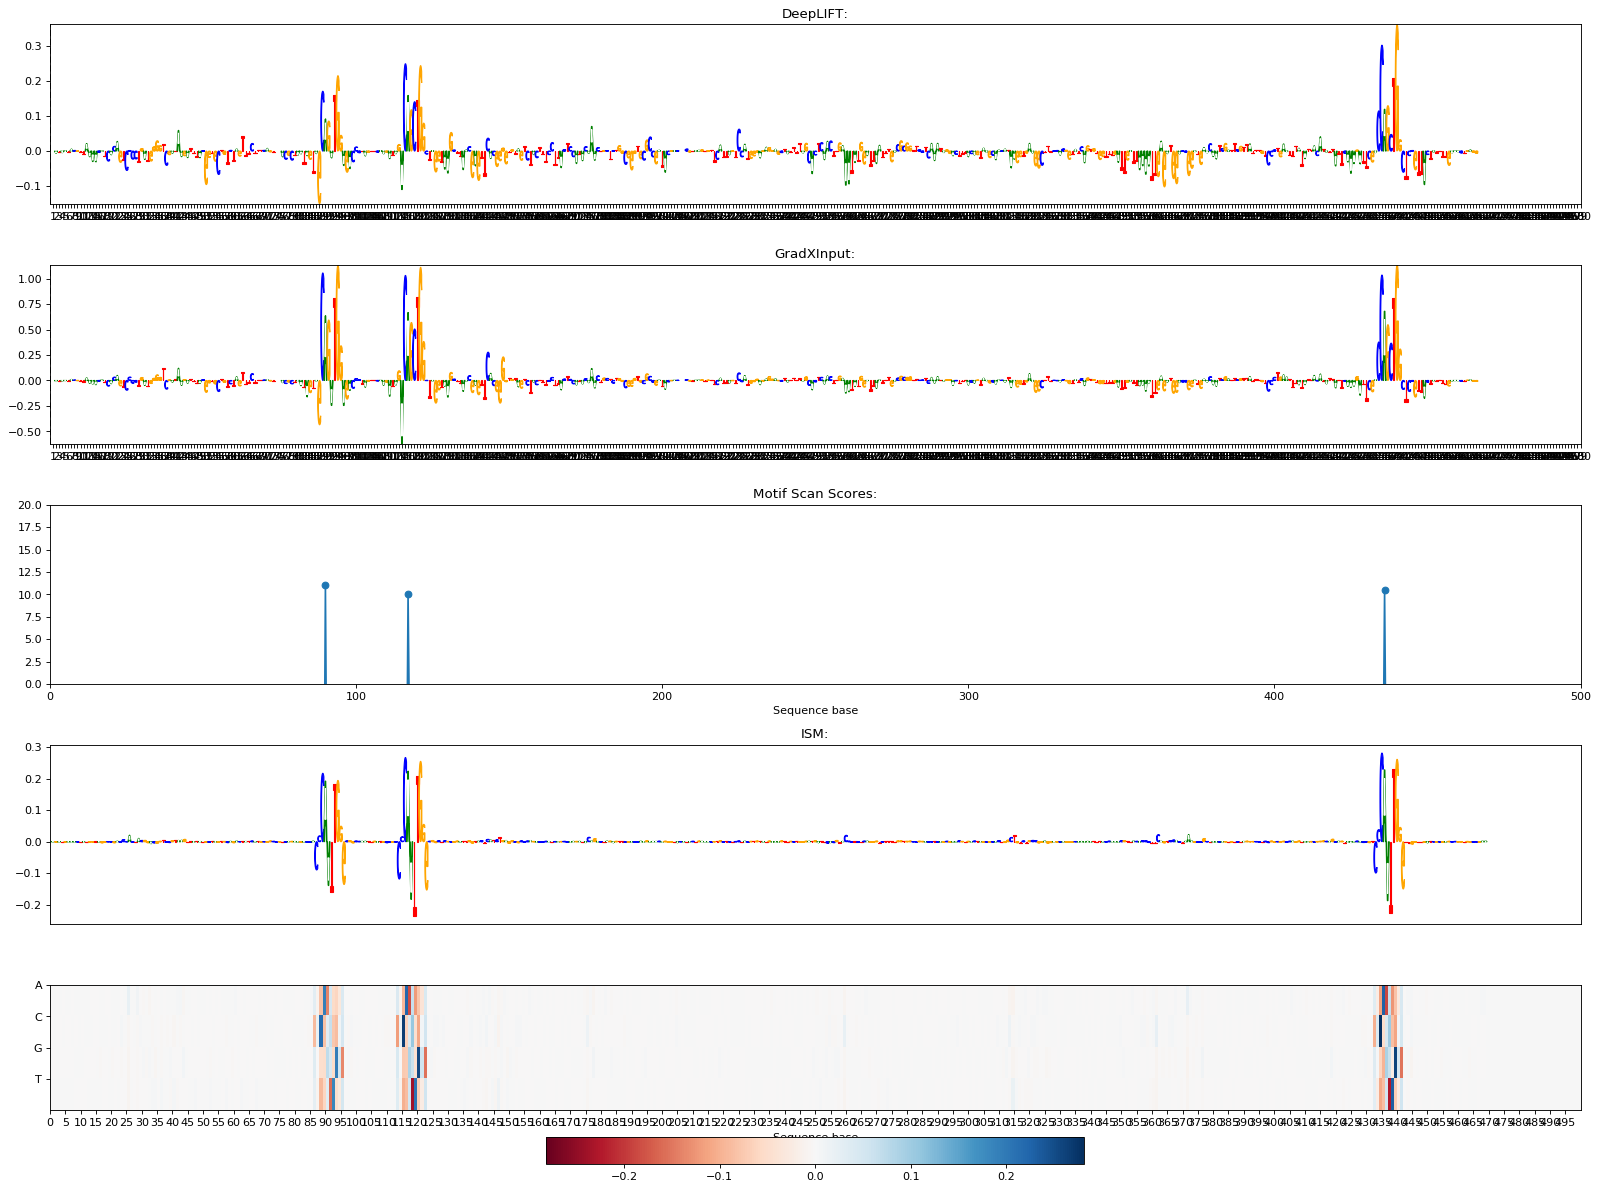

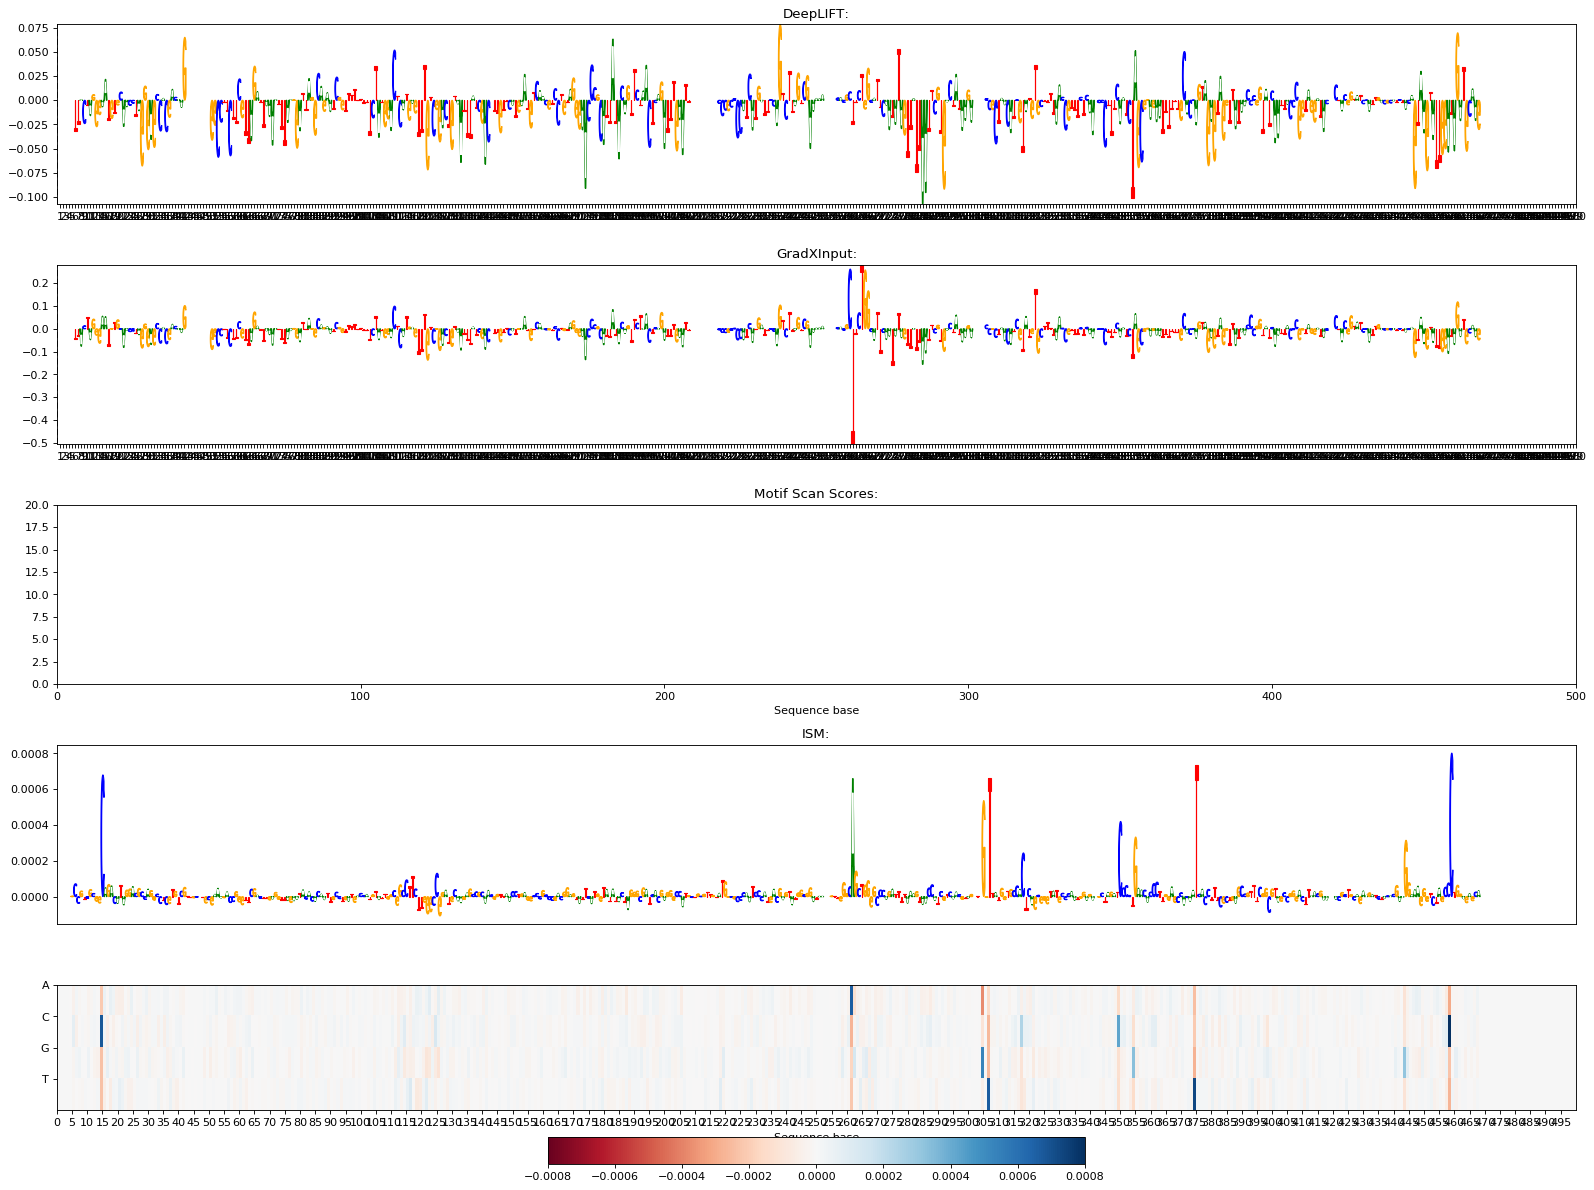

In [20]:
density_detection_pos_X,density_detection_neg_X,density_detection_pos_interpretations,density_detection_neg_interpetations=analyze(density_detection_model,density_detection_data,
                                             1,
                                             1,
                                             "tut3_density_detection.hdf5",
                                             ["TAL1_known4"],
                                             (0,500))

## Homotypic motif density localization <a name='6'>
<a href=#outline>Home</a>

In [21]:
#Define simulation parameters 
density_localization_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
density_localization_data=get_simulation_data("simulate_motif_density_localization",
                               density_localization_parameters,
                               validation_set_size=3200,test_set_size=4000)



In [22]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
density_localization_model=Sequential() 
density_localization_model.add(Conv2D(filters=5,kernel_size=(1,10),input_shape=density_localization_data.X_train.shape[1::]))
density_localization_model.add(Activation('relu'))
density_localization_model.add(MaxPooling2D(pool_size=(1,10)))
density_localization_model.add(Flatten())
density_localization_model.add(Dense(1))
density_localization_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
density_localization_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

In [23]:
pos_X, neg_X, ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos, dl_neg=analyze(density_localization_model,density_localization_data,1,1)

TypeError: analyze() missing 3 required positional arguments: 'outfname', 'motif_names', and 'xlim_for_plot'

In [ ]:
plot_seq_importance(dl_pos,pos_X,xlim=(220,275),title="Positive")
plot_seq_importance(dl_neg,neg_X,xlim=(220,275),title="Negative")

## Multiple motifs (multi-task)<a name='7'>
<a href=#outline>Home</a>

In [ ]:
#Define simulation parameters 
multi_motif_parameters = {
    "motif_names": ["CTCF_known1","ZNF143_known2","SIX5_known1"],
    "seq_length": 500,
    "min_num_motifs": 0,
    "max_num_motifs": 1, 
    "num_seqs": 20000,
    "GC_fraction": 0.4}

#Get simulation data
multi_motif_data=get_simulation_data("simulate_multi_motif_embedding",
                               multi_motif_parameters,
                               validation_set_size=3200,test_set_size=4000)



In [ ]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
multi_motif_model=Sequential() 
multi_motif_model.add(Conv2D(filters=20,kernel_size=(1,20),input_shape=multi_motif_data.X_train.shape[1::]))
multi_motif_model.add(Activation('relu'))
multi_motif_model.add(MaxPooling2D(pool_size=(1,10)))
multi_motif_model.add(Flatten())
multi_motif_model.add(Dense(3))
multi_motif_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
multi_motif_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

In [ ]:
pos_X, neg_X, ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos, dl_neg=analyze(multi_motif_model, multi_motif_data,1,1)

In [ ]:
plot_seq_importance(dl_pos,pos_X,xlim=(220,275),title="Positive")
plot_seq_importance(dl_neg,neg_X,xlim=(220,275),title="Negative")

## Heterotypic motifs spatial grammar<a name='8'>
<a href=#outline>Home</a>

In [ ]:
#Define simulation parameters 
heterodimer_parameters = {
    "motif1": "SPI1_known4",
    "motif2": "IRF_known1",
    "seq_length": 500,
    "min_spacing": 2,
    "max_spacing": 5, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
heterodimer_data=get_simulation_data("simulate_heterodimer_grammar",
                               heterodimer_parameters,
                               validation_set_size=3200,test_set_size=4000)

In [ ]:
heterodimer_model=Sequential()
heterodimer_model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
heterodimer_model.add(Activation("relu"))
heterodimer_model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
heterodimer_model.add(Activation("relu"))
heterodimer_model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
heterodimer_model.add(Activation("relu"))
heterodimer_model.add(MaxPooling2D(pool_size=(1,35)))    
heterodimer_model.add(Flatten())
heterodimer_model.add(Dense(num_tasks))
heterodimer_model.add(Activation("sigmoid"))
heterodimer_model.compile(optimizer='adam',loss='binary_crossentropy')


In [ ]:
pos_X, neg_X, ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos, dl_neg=analyze(heterodimer_model,heterodimer_data,1,1)

In [ ]:
plot_seq_importance(dl_pos,pos_X,xlim=(220,275),title="Positive")
plot_seq_importance(dl_neg,neg_X,xlim=(220,275),title="Negative")

## Conclusions<a name='9'>
<a href=#outline>Home</a>